In [2]:
library(readr)
library(glmnet)
library(tidyr)
library(dplyr, warn=F)
library(glmnet)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-2


Attaching package: ‘tidyr’

The following object is masked from ‘package:Matrix’:

    expand



## Read and prepare features

In [3]:
part_df = readr::read_tsv('data/partition.tsv.gz')
dwpc_df = readr::read_tsv('data/dwpc.tsv.gz')

In [5]:
spread_df = part_df %>%
  dplyr::inner_join(
    dwpc_df %>%
    dplyr::select(-path_count) %>%
    tidyr::spread(key = metapath, value = dwpc)
  )

Joining by: c("compound_id", "disease_id")


In [6]:
x = spread_df %>%
  dplyr::select(-(compound_id:percentile)) %>%
  as.matrix()
y = spread_df$indication

## Fit model and evaluate

In [7]:
lasso = hetior::glmnet_train(x, y, alpha=1)

In [8]:
# Positive coefficients
lasso$coef_df %>%
  dplyr::arrange(desc(zcoef)) %>%
  dplyr::filter(zcoef > 0)

,feature,coef,zcoef
1,CcSEcCiD,32.69709,2.391688
2,CiDiCiD,37.85164,2.290817
3,CtGtCiD,15.25964,1.136177
4,CsCsCiD,8.675185,0.7225817
5,CtGaD,21.45194,0.6782444
6,CiDaGaD,9.698123,0.4539967
7,CiDsD,6.792177,0.4104101
8,CsCiD,3.863816,0.346301
9,CiDlAlD,6.443075,0.2873377
10,CiDsDsD,2.607129,0.1275331


In [11]:
lasso$vtm[c('auroc', 'auprc')]

$auroc
[1] 0.9665569

$auprc
[1] 0.9236064

In [10]:
pred_df = spread_df %>%
  dplyr::select(compound_id:percentile)
pred_df$y_pred = lasso$y_pred
pred_df = pred_df %>%
  dplyr::arrange(disease_name, desc(y_pred))
pred_df %>% readr::write_csv('data/predictions.csv')

## Feature correlation plot

In [33]:
nonzero_df = dwpc_df %>%
  dplyr::group_by(metapath) %>%
  dplyr::summarize(nonzero = mean(path_count > 0))

cor_features = dplyr::filter(nonzero_df, nonzero >= 0.25)$metapath

In [34]:
order_by_clustering <- function(cor_mat) {
  clust <- hclust(dist(cor_mat), method='ward.D2')
  return(colnames(cor_mat)[clust$order])
}

cor_mat = cor(x[, cor_features])
features_sorted = order_by_clustering(cor_mat)
cor_mat = cor_mat[features_sorted, features_sorted]
cor_mat[lower.tri(cor_mat, diag=TRUE)] <- NA

In [35]:
cor_df = cor_mat %>% as.data.frame %>%
  dplyr::add_rownames('feature_0') %>% 
  tidyr::gather(feature_1, correlation, -feature_0, na.rm = TRUE)

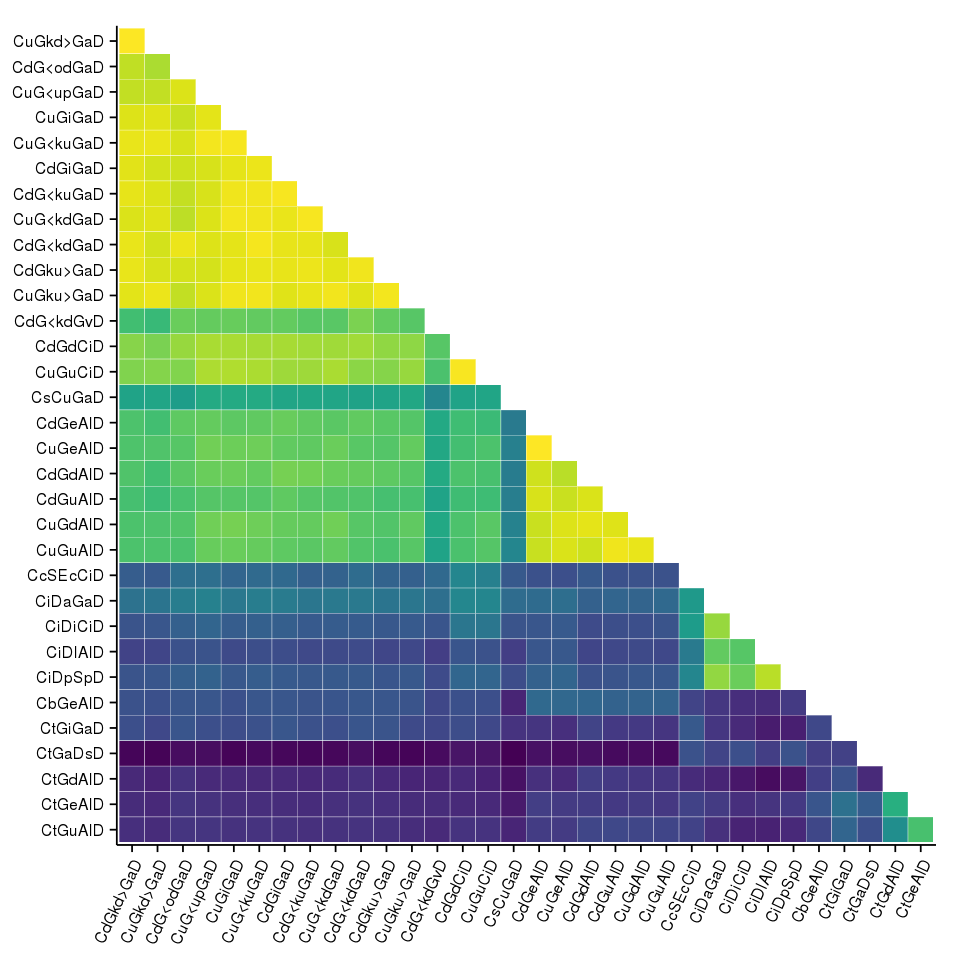

In [37]:
w = 8; h = 8
options(repr.plot.width=w, repr.plot.height = h)
xlimits = features_sorted[-length(features_sorted)]
ylimits = rev(features_sorted[-1])
cor_df %>%
  ggplot2::ggplot(ggplot2::aes(feature_0, feature_1, fill=correlation)) +
  ggplot2::theme_bw() +
  ggplot2::geom_tile(color='white') +
  ggplot2::scale_x_discrete(limits=xlimits) + 
  ggplot2::scale_y_discrete(limits=ylimits) +
  ggplot2::theme(axis.text.x=ggplot2::element_text(angle=65, hjust=1)) +
  ggplot2::xlab(NULL) + ggplot2::ylab(NULL) + ggplot2::coord_fixed() +
  ggplot2::scale_fill_gradientn(colours=viridis::viridis(200), guide=FALSE) +
  ggplot2::theme(plot.background=ggplot2::element_blank(),
                 panel.grid.major=ggplot2::element_blank(),
                 panel.grid.minor=ggplot2::element_blank(),
                 panel.border=ggplot2::element_blank(),
                 axis.line=ggplot2::element_line(color='black'))